In [10]:
#imports here
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from PIL import Image, ImageOps, ImageEnhance
import os
import re
import torch.optim as optim
from torch.autograd import Variable
#!pip3 install kornia
from kornia.color import RgbToGrayscale
from sklearn.model_selection import train_test_split
import math
print('Imports Done')

c:\Users\thire\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


Imports Done


The early stopping class is from here this github, and the credit goes to him. I only use it for early stopping. https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb

In [2]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Below is for plotting each image in R, G ,B

In [3]:
os.chdir(os.getcwd())

In [4]:
def load_images(folder_path):
    image_array = []
    
    # List all files in the folder
    file_list = os.listdir(folder_path)
    
    # Filter only TIFF files
    tiff_files = [file for file in file_list if file.lower().endswith('.tif') or file.lower().endswith('.tiff')]
    gif_files = [file for file in file_list if file.lower().endswith('.gif')]
    # Load each TIFF image and store it in the array
    if len(tiff_files) > 0:
        print('Getting tiff files')
        for file in tiff_files:
            file_path = os.path.join(folder_path, file)
            try:
                # Open TIFF image using PIL
                img = Image.open(file_path)
                
                # Convert PIL Image to numpy array
                img_array = np.array(img)
                
                # Append to the image array
                image_array.append(img_array)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    if len(gif_files) > 0:
        print('Getting gif files')
         # Load GIF images
        for file in gif_files:
            file_path = os.path.join(folder_path, file)
            try:
                img = Image.open(file_path)
                img_array = np.array(img)
                image_array.append(img_array)
            except Exception as e:
                print(f"Error loading {file}: {e}")

    return np.asarray(image_array)
XtrainPath = os.getcwd() + '/Data/DRIVE/training/images'
Train_img = load_images(XtrainPath)
YtrainPath = os.getcwd() + '/Data/DRIVE/training/1st_manual'
Label_img = load_images(YtrainPath)

Getting tiff files
Getting gif files


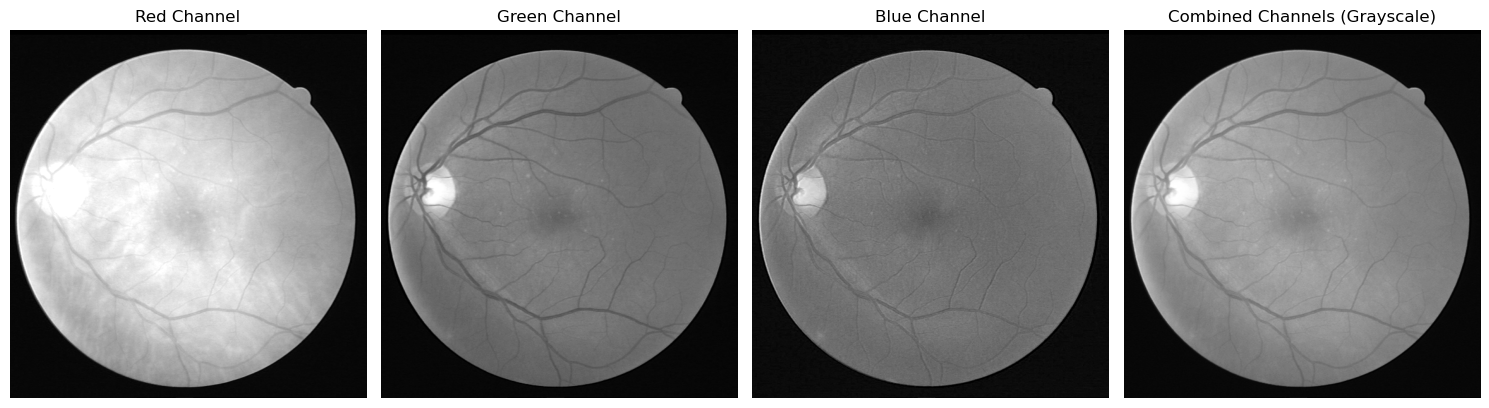

In [5]:
# Create a 1x4 subplot grid
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
#color = 'CMRmap'
color = 'gray'
# Display each channel in grayscale in a separate subplot
axs[0].imshow(Train_img[0][:, :, 0], cmap=color)
axs[0].set_title('Red Channel')
axs[0].axis('off')

axs[1].imshow(Train_img[0][:, :, 1], cmap=color)
axs[1].set_title('Green Channel')
axs[1].axis('off')

axs[2].imshow(Train_img[0][:, :, 2], cmap=color)
axs[2].set_title('Blue Channel')
axs[2].axis('off')

combined_channels_gray = 0.299 * Train_img[0][:, :, 0] + 0.587 * Train_img[0][:, :, 1] + 0.114 * Train_img[0][:, :, 2]
axs[3].imshow(combined_channels_gray, cmap=color)
axs[3].set_title('Combined Channels (Grayscale)')
axs[3].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Save or display the plot
output_dir = f'{os.getcwd()}/OutPut'
os.makedirs(output_dir, exist_ok=True)
output_path = f'{output_dir}/Original_Row_Grayscale.png'

plt.savefig(output_path, dpi=400, bbox_inches='tight')
plt.show()


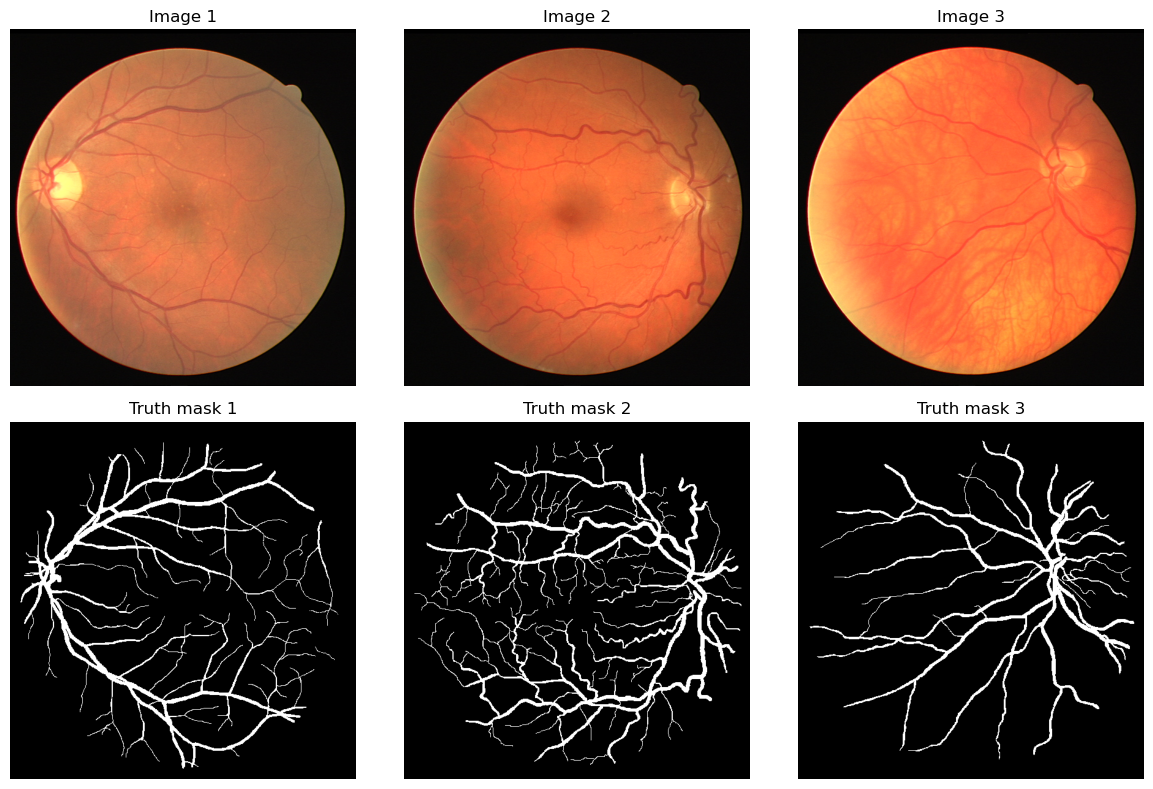

In [6]:
# Create a subplot grid
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Iterate through the images and plot them
for i in range(3):
    axs[0][i].imshow(Train_img[i], cmap='gray')  # Replace 'gray' with the desired colormap
    axs[0][i].set_title(f'Image {i + 1}')
    axs[1][i].imshow(Label_img[i], cmap='gray')  # Replace 'gray' with the desired colormap
    axs[1][i].set_title(f'Truth mask {i + 1}')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
# Adjust layout for better spacing
plt.tight_layout()
output_path = f'{output_dir}/SampleTrainImages.png'
plt.savefig(output_path, dpi=400, bbox_inches='tight')
# Show the plot
plt.show()

# DL

## Below is from the BA project, With UNet


In [7]:
#unet implementation here
#Form the Bachelor project
#This is for each "block", each block does the convolutional step
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding= 1)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding= 1)
        self.BN    = nn.BatchNorm2d(out_ch, affine=False)
        self.Drop  = nn.Dropout(0.01)

    def forward(self, x):
        return self.relu( self.Drop(self.BN (self.conv2( self.relu( self.Drop( self.BN( self.conv1(x) ) ) ) ))))

#This is the downsampling step/ the encoding step.
class Encoder(nn.Module):
    def __init__(self, chs=(1, 8, 16, 32, 64, 128)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(kernel_size = 2, stride = 2)

    def forward(self, input):
        features = []
        for block in self.enc_blocks:
            input = block(input)
            features.append(input)
            input = self.pool(input)
        return features

#This is the decoder, or where we upsample again, / putting everything together
class Decoder(nn.Module):
    def __init__(self, chs=(128, 64, 32, 16, 8)):
        super().__init__()
        self.chs         = chs
        self.up    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2, padding=0) for i in range(len(chs)-1)]) #maybe use torch unpool "max unpool 2D"
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, Input, encoder_features):
        for i in range(len(self.chs)-1):
            Input        = self.up[i](Input)
            enc_ftrs = self.crop(encoder_features[i], Input)
            Input        = torch.cat([Input, enc_ftrs], dim=1)
            Input        = self.dec_blocks[i](Input)
        return Input

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

#The final UNet Call
class UNet(nn.Module):
    def __init__(self, enc_chs=(1, 8, 16, 32, 64, 128), dec_chs=(128, 64, 32, 16, 8), num_class=1): #Change num_class to handle 4 channels
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.sig         = nn.Sigmoid() #clamps the output to between 1 and 0
        self.num_class   = num_class #think of it as the number of object classes to segment

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        out      = self.sig(out) #bad with a activation function as last layer? is the data normalized?
        out = F.interpolate(out, (x.shape[2], x.shape[3]), mode = 'nearest')
        return out

In [8]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()

    def forward(self, pred, target):
        smooth = 1. # added smooth to avoid division by zero, if foreground contains no value
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )
'''
Config
----------------------------------------------------------------------------
'''
Epoch = 200
Learning_rate = 0.01
momentum = 0.9 #only for SGD optimizer
#Loss = nn.BCELoss()
Loss = diceloss() #Diceloss better for small details CURRENT OUTPUT IS FOR BCELOSS
Optimizer = optim.Adam
Delta = 0.001
Patience = 10
'''
----------------------------------------------------------------------------
'''

def SwApAxis(Arr_Img, channel, Grayscale):
    '''
    Swaps axies such that we have. (now also supports selecting RGB channel)
    WxHxC
    instead of
    CxWxH
    also adds a dimension for the unet implementation and converts it to a torch
    '''
    gray = RgbToGrayscale()
    temp_Arr = []
    if (Grayscale == True):
        for img in Arr_Img:
            img = np.asarray(img, dtype = np.float32)
            img /= 255.0
            temp = np.swapaxes(img, 0,-1)
            temp1 = np.asarray(np.swapaxes(temp, 1, -1))
            temp_Arr.append(temp1)
        return gray(torch.from_numpy(np.asarray(temp_Arr)))

    if ((channel == 0) or (channel == 1) or (channel == 2) ):
        for img in Arr_Img:
            img = np.asarray([img[:][:,:,channel]], dtype= np.float32)
            img /= 255.0
            temp_Arr.append(img)
 #       plt.imshow(temp_Arr[0][0])
 #       plt.show()
        return torch.from_np(np.asarray(temp_Arr))
    else:
        for img in Arr_Img:
            img = np.asarray(img, dtype= np.float32)
            img /= 255.0
            temp = np.swapaxes(img,0,-1)
            temp1 = np.asarray(np.swapaxes(temp, 1, -1))
            temp_Arr.append(temp1)
        return (torch.from_numpy(np.asarray(temp_Arr))) #Redoes the Colors to gray-scale


In [9]:
new_train = SwApAxis(Train_img, 1, Grayscale = True)

def Normalize_labels(Labels):
    new_arr = []
    for i in range(np.asarray(Label_img).shape[0]):
        temp = np.asarray(Label_img[i], dtype= float)
        temp /= 255.0
        new_arr.append(temp)
    return new_arr
New_Label_img = Normalize_labels(Label_img)

#new_Test_img = SwApAxis(Test_img, 1, True)


## Training loop


In [10]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(new_train, New_Label_img, test_size = 0.3, shuffle = False) # random state is nice, but can't check with output after, maybe for testing it would be nice
print('X_train shape: ', X_Train.shape,
    '\nY_train shape: ', len(Y_Train),
    '\nX_Val shape: ', X_Val.shape,
    '\nY_Val shape: ',len( Y_Val))

X_train shape:  torch.Size([14, 1, 584, 565]) 
Y_train shape:  14 
X_Val shape:  torch.Size([6, 1, 584, 565]) 
Y_Val shape:  6


In [11]:
X_Train, X_test, Y_Train, Y_test = train_test_split(X_Train, Y_Train, test_size = 0.2, shuffle = False) # random state is nice, but can't check with output after, maybe for testing it would be nice
print('X_train shape: ', X_Train.shape,
    '\nY_train shape: ', len(Y_Train),
    '\nX_test shape: ', X_test.shape,
    '\nY_test shape: ',len( Y_test))

X_train shape:  torch.Size([11, 1, 584, 565]) 
Y_train shape:  11 
X_test shape:  torch.Size([3, 1, 584, 565]) 
Y_test shape:  3


In [12]:
def Evalf(model, loss, X_val, Y_val):
    '''
    Takes current epoch model, Trains the X_val data on it
    Returns the Loss output from the given "loss" function.
    '''
    out = model(X_val)
    loss_out = loss(out, Y_val)
    return loss_out.item()

def Evalf_Test(model, X_test):
    out = model(X_test)
    for i in range(out.shape[0]):
        temp = np.asarray(out[i].cpu().detach().numpy())
        temp = temp[0]
        im = Image.fromarray((temp*255).astype(np.uint8))
        #im = im.save(f'/content/drive/My Drive/EML/Output/DiceLoss/Test_out/{i+1}_test.tif')

def Train_loop(X_Train, Y_Train, X_Val, Y_Val, model, epochs, lr, OP, loss_Function, patience, delta):
    print('Choosen Model: ','UNet',
    '\nNumber of Epoch: ' + str(epochs),
    '\nOptimizer: ' + str(OP),
    '\nLearning rate: ' + str(lr),
    '\nLoss function: ' + str(loss_Function)+ '\n'
    )
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    if device == 'cpu':
        print('Not gonna run on the CPU ¯\_(ツ)_/¯')
        return None, None, None
    Train_loss = []
    optimizer = OP(model.parameters(), lr = lr)
    #optimizer = optim.SGD(model.parameters(), lr= lr, momentum = 0.9)
    loss_function = loss_Function
    total_losses = []

    #To get labels into the correct shape

    model.to(device)
    Validation = []
    Val_loss = []
    early_stopping = EarlyStopping( patience=patience, verbose=True, delta = delta)

    for epoch in range(epochs):
        running_loss = 0.0
        optimizer.zero_grad()
        out = model(X_Train.to(device))
        loss = loss_function(out, torch.tensor(Y_Train).float().to(device))
        loss.backward()
        optimizer.step()
        total_losses.append(loss.item())
        running_loss = loss.item() # each epoch loss

        temp = Evalf(model, loss_function, X_Val.to(device), torch.tensor(Y_Val).float().to(device))
        Validation.append(temp)

        print('Current Epoch:', epoch, 'Train loss for this epoch', (running_loss))
        early_stopping(temp, model)

        if early_stopping.early_stop:
            print("Early stopping ---------- Epoch: ", epoch)
            break
        else:
            continue
    # for i in range(out.shape[0]):
    #     temp = np.asarray(out[i].cpu().detach().numpy())
    #     temp = temp[0]
    #     im = Image.fromarray((temp*255).astype(np.uint8))
    #         #im = im.save(f'/content/drive/My Drive/EML/Output/DiceLoss/Test_out/{i+1}_test.tif')
    #     im = im.save(f'OutPut/Segmentation/DSC_{i+1}.tif')  
    return total_losses, Validation, out


model = UNet(enc_chs=(1, 8, 16, 32, 64, 128), dec_chs=(128, 64, 32, 16, 8), num_class = 1)
Loss, Validation, out = Train_loop(X_Train
                                   , Y_Train
                                   , X_Val
                                   ,Y_Val
                                   , model
                                   , epochs = Epoch, lr = Learning_rate
                                   , OP = Optimizer
                                   , loss_Function = Loss
                                   , patience = Patience
                                   , delta = Delta)

print('done')


Choosen Model:  UNet 
Number of Epoch: 300 
Optimizer: <class 'torch.optim.adam.Adam'> 
Learning rate: 0.01 
Loss function: diceloss()

cuda:0


C:\Users\thire\AppData\Local\Temp\ipykernel_9364\3573332311.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  loss = loss_function(out, torch.tensor(Y_Train).float().to(device))


Current Epoch: 0 Train loss for this epoch 0.7772843837738037
Validation loss decreased (inf --> 0.755047).  Saving model ...
Current Epoch: 1 Train loss for this epoch 0.7626630067825317
Validation loss decreased (0.755047 --> 0.735207).  Saving model ...
Current Epoch: 2 Train loss for this epoch 0.7440640926361084
Validation loss decreased (0.735207 --> 0.723054).  Saving model ...
Current Epoch: 3 Train loss for this epoch 0.7336671352386475
Validation loss decreased (0.723054 --> 0.718443).  Saving model ...
Current Epoch: 4 Train loss for this epoch 0.729037880897522
Validation loss decreased (0.718443 --> 0.713441).  Saving model ...
Current Epoch: 5 Train loss for this epoch 0.7244980335235596
Validation loss decreased (0.713441 --> 0.706205).  Saving model ...
Current Epoch: 6 Train loss for this epoch 0.7177947759628296
Validation loss decreased (0.706205 --> 0.696232).  Saving model ...
Current Epoch: 7 Train loss for this epoch 0.7086649537086487
Validation loss decreased (

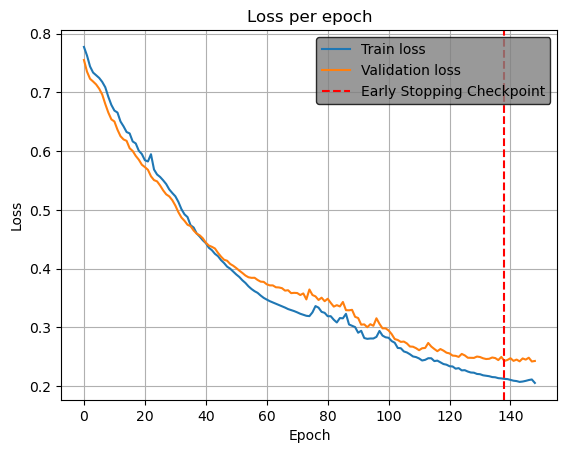

Last Train loss:  0.20559144020080566 
Last Val loss:  0.24294334650039673


In [22]:
X_axis = []
for i in range (len(Loss)):
    X_axis.append(i)

plt.plot(X_axis, Loss, label = 'Train loss')
plt.plot(X_axis, Validation, label = 'Validation loss')
minposs = Validation.index(min(Validation))+1-10
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
legend = plt.legend(loc = 'upper right', frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('grey')
frame.set_edgecolor('black')
plt.xlabel ('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epoch')
plt.grid()
plt.savefig(f'Output/LossPrEpoch.png', dpi = 400, bbox_inches = 'tight')
plt.show()
print('Last Train loss: ', Loss[-1],'\n'
        'Last Val loss: ', Validation[-1])

In [19]:
def evalModel(xtest, ytest):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = UNet()
    model.to(device)
    model.load_state_dict(torch.load('checkpoint.pt')) # load saved best model
    output = model(xtest.to(device))
    #print(output.shape)
    out = diceloss().forward(output, torch.tensor(ytest).float().to(device))
    print(f'Accuracy: {1-out}')

    return out, output

out, segmentation = evalModel(X_test, Y_test)


cuda:0
Accuracy: 0.7161463499069214


In [21]:
print(np.round(1 - 0.24294334650039673, 3))
print(np.round(0.7161463499069214, 3))


0.757
0.716


In [15]:
from PIL import Image, ImageOps, ImageEnhance
for i in range(segmentation.shape[0]):
    temp = np.asarray(segmentation[i].cpu().detach().numpy())
    temp = temp[0]
    im = Image.fromarray((temp*255).astype(np.uint8))
        #im = im.save(f'/content/drive/My Drive/EML/Output/DiceLoss/Test_out/{i+1}_test.tif')
    im = im.save(f'OutPut/Segmentation/DSC_{i+1}.tif')

In [16]:
BREAK POINT

SyntaxError: invalid syntax (3797757315.py, line 1)

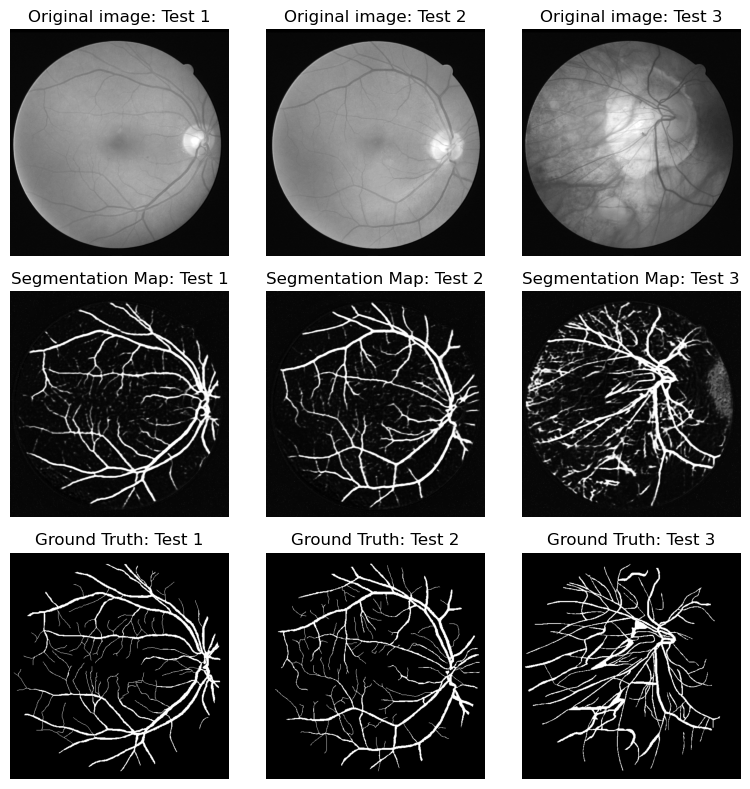

In [36]:
fig, ax = plt.subplots(3, 3, figsize = (8, 8))

for i in range(segmentation.shape[0]):
    temp = np.asarray(segmentation[i].cpu().detach().numpy())
    temp2 = np.asarray(Y_test[i])
    temp3 = np.asarray(X_test[i].cpu().detach().numpy())
    ax[0][i].imshow(temp3[0], cmap = 'gray')
    ax[0][i].axis('off')
    ax[0][i].set_title(f'Original image: Test {i+1}')
    ax[1][i].imshow(temp[0], cmap = 'gray')
    ax[1][i].axis('off')
    ax[1][i].set_title(f'Segmentation Map: Test {i+1}')
    ax[2][i].imshow(temp2, cmap = 'gray')
    ax[2][i].axis('off')
    ax[2][i].set_title(f'Ground Truth: Test {i+1}')
    fig.tight_layout()
plt.savefig(f'Output/OutPutSegmentation.png', dpi = 400, bbox_inches = 'tight')
plt.show()



# Clustering

In [37]:
data = X_Val.detach().cpu().numpy()[0][0]
#data = data.reshape(-1, 1)  # Reshape the image into a column vector
print(data.shape)

(584, 565)


Best solution is [ 0.5285568   0.46919493 -2.49830265  0.58881426  0.01162006]
Fitness of the best solution is 0.00014120987902902738
Best solution found after 95 generations


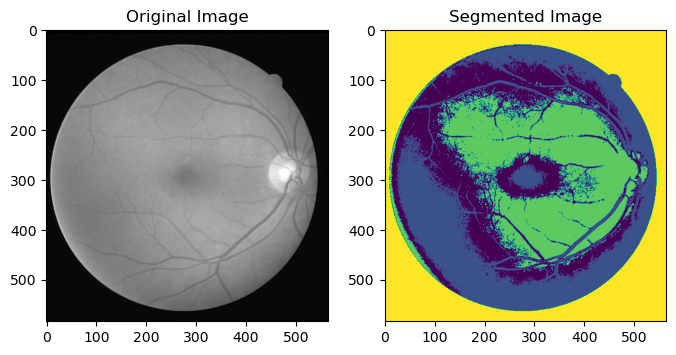

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pygad


image = X_test.detach().cpu().numpy()[0][0]
# Flatten the image matrix
image_flat = image.flatten().reshape(-1, 1)

# Define the number of clusters (segments)
num_segments = 5
crossover = True
mutation = True


def euclidean_distance(X, Y):
    return np.sqrt(np.sum(np.power(X - Y, 2), axis=1))

def segment_data(solution, solution_idx):
    global num_segments, image
    pixel_value_length = image_flat.shape[1]
    segment_centers = []
    all_segments_dists = []
    segments = []
    segments_sum_dist = []

    for seg_idx in range(num_segments):
        segment_centers.append(solution[pixel_value_length * seg_idx:pixel_value_length * (seg_idx + 1)])
        segment_center_dists = euclidean_distance(image_flat, segment_centers[seg_idx])
        all_segments_dists.append(np.array(segment_center_dists))

    segment_centers = np.array(segment_centers)
    all_segments_dists = np.array(all_segments_dists)

    segment_indices = np.argmin(all_segments_dists, axis=0)
    for seg_idx in range(num_segments):
        segments.append(np.where(segment_indices == seg_idx)[0])
        if len(segments[seg_idx]) == 0:
            segments_sum_dist.append(0)
        else:
            segments_sum_dist.append(np.sum(all_segments_dists[seg_idx, segments[seg_idx]]))

    segments_sum_dist = np.array(segments_sum_dist)

    return segment_centers, all_segments_dists, segment_indices, segments, segments_sum_dist

def fitness_func(_, solution, solution_idx):
    _, _, _, _, segments_sum_dist = segment_data(solution, solution_idx)

    fitness = 1.0 / (np.sum(segments_sum_dist) + 0.00000001)
    return fitness

num_genes = num_segments * image_flat.shape[1]

if crossover:
    CrossOver = "single_point"
    crossover_probability = 0.5
else:
    CrossOver = None
    crossover_probability = None

if mutation:
    Mutation = "random"
    mutation_percent_genes = 10
else:
    Mutation = None
    mutation_percent_genes = None


ga_instance = pygad.GA(num_generations=100
                       , sol_per_pop=20
                       , num_parents_mating=5
                       #,init_range_low=0
                       #,init_range_high=1
                       , crossover_type = CrossOver
                       , crossover_probability = crossover_probability
                       , keep_parents=2
                       , num_genes=num_genes
                       , fitness_func=fitness_func
                       , suppress_warnings=True
                       , mutation_percent_genes=mutation_percent_genes
                       , mutation_type = Mutation
                       , mutation_probability = 0.5
                       , save_solutions = True)

ga_instance.run()

best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
print("Best solution is {bs}".format(bs=best_solution))
print("Fitness of the best solution is {bsf}".format(bsf=best_solution_fitness))
print("Best solution found after {gen} generations".format(gen=ga_instance.best_solution_generation))

segment_centers, all_segments_dists, segment_indices, segments, segments_sum_dist = segment_data(best_solution, best_solution_idx)

# Reshape the segmented image to its original shape
final_segmentation = np.zeros_like(image)
for seg_idx in range(num_segments):
    final_segmentation.flat[segments[seg_idx]] = seg_idx + 1

# Display the original and segmented images using matplotlib
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(final_segmentation, cmap='viridis')
plt.title('Segmented Image')
plt.show()


Note that we are interested in minimizing the sum of squares. so lower is better. However there might be some false positives/negatives here which makes the data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


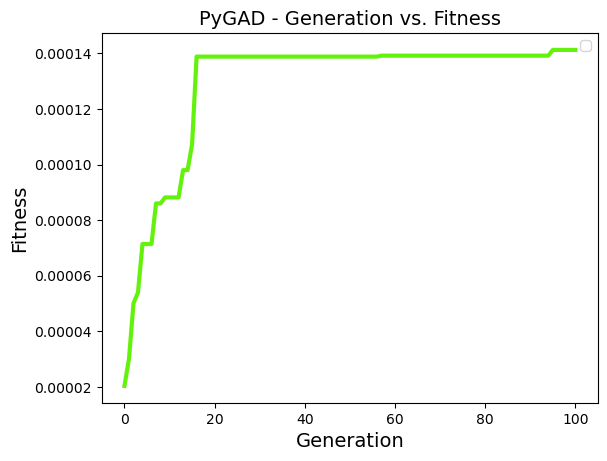

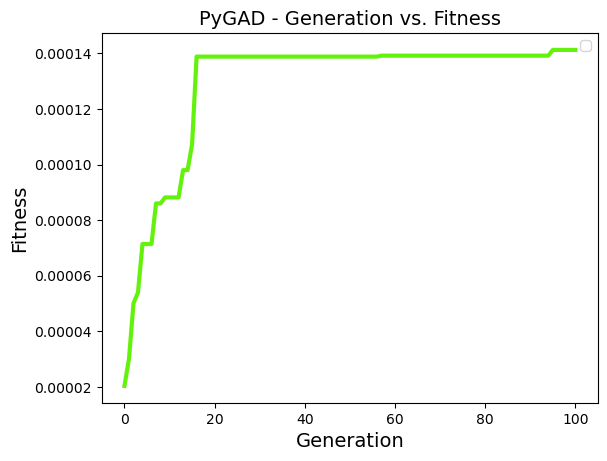

In [48]:
ga_instance.plot_fitness(label = ['idk'])

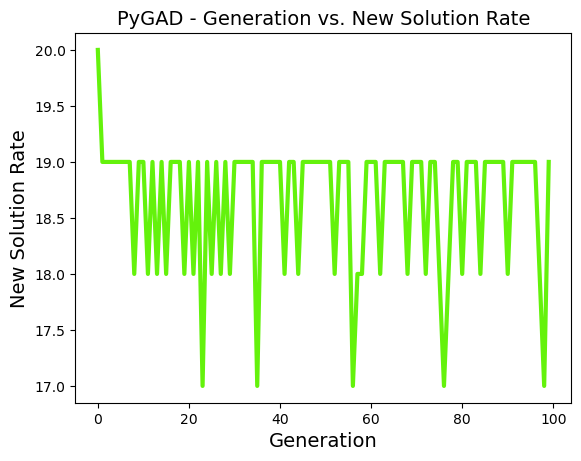

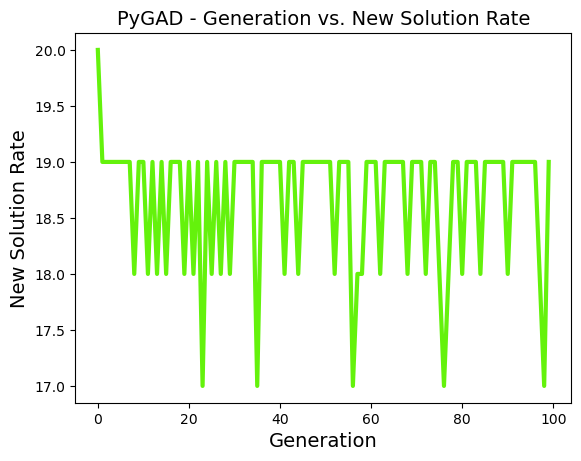

In [49]:
ga_instance.plot_new_solution_rate()

In [50]:
print(final_segmentation[300][0:500])

[5. 5. 5. 5. 5. 5. 5. 5. 2. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1.
 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 1. 2. 2.
 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 4. 4. 1. 1. 4. 4. 4. 4.
 1. 4. 1. 4. 4. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 4. 4. 4. 1. 1. 1. 4. 4. 4.
 1. 1. 1. 1. 1. 4. 4. 1. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1.

5 0
5 1
5 2
5 3
5 4


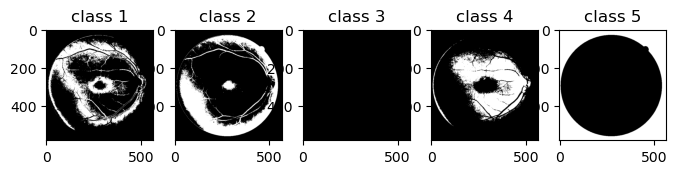

In [51]:
plt.figure(figsize=(8, 4))
for i in range(num_segments):
    print(num_segments, i)
    temp1 = final_segmentation == i+1
    plt.subplot(1, num_segments, i+1)
    plt.imshow(temp1, cmap='gray')
    plt.title(f'class {i+1}')
# temp2 = final_segmentation == 3
# plt.subplot(1, 3, 2)
# plt.imshow(temp2, cmap='gray')
# plt.title('temp2')
# plt.show()
# temp3 = final_segmentation == 2
# plt.subplot(1, 3, 3)
# plt.imshow(temp3, cmap='gray')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

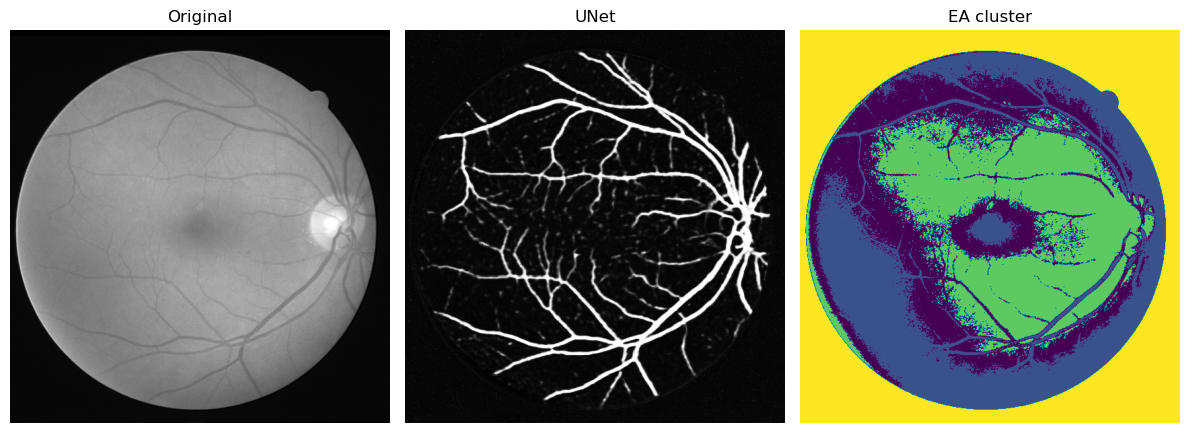

In [60]:
fig, ax = plt.subplots(1, 3, figsize = (12, 8))

ax[2].imshow(final_segmentation, cmap='viridis')
ax[2].set_title('EA cluster')
ax[2].axis('off')


ax[1].imshow(segmentation[0].detach().cpu().numpy()[0], cmap='gray')
ax[1].set_title('UNet')
ax[1].axis('off')
ax[0].imshow(X_test[0].detach().cpu().numpy()[0], cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')
plt.tight_layout()
plt.savefig('OutPut/SampleimagesTeaser.png', dpi = 400, bbox_inches = 'tight')
plt.show

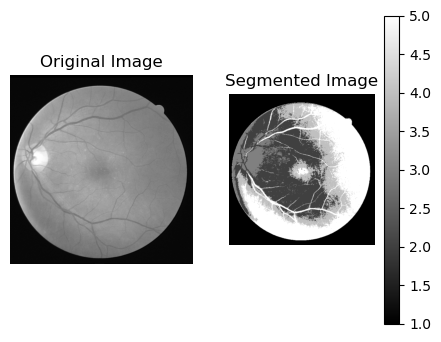

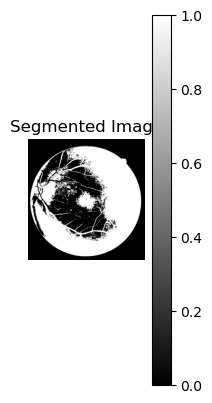

In [ ]:
# Display the original and segmented images using matplotlib
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 3, 2)

plt.imshow(final_segmentation, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')
plt.colorbar()
plt.show()
temp = 2 < final_segmentation
#temp = temp < 2
temp.astype(int)
plt.subplot(1, 3, 3)
plt.imshow(temp, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')
plt.colorbar()
plt.show()

# Testing with different dataset

Import the MNIST dataset and try the same algorithm on 2 classes.

In [11]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [12]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir(os.getcwd())
a = torch.load('Data2/training.pt')
b = torch.load('Data2/test.pt')

Training shape:
X:  torch.Size([60000, 28, 28]) 
Y:  torch.Size([60000])
The different classes
[0 1 2 3 4 5 6 7 8 9]
In total there are 10 Training classes


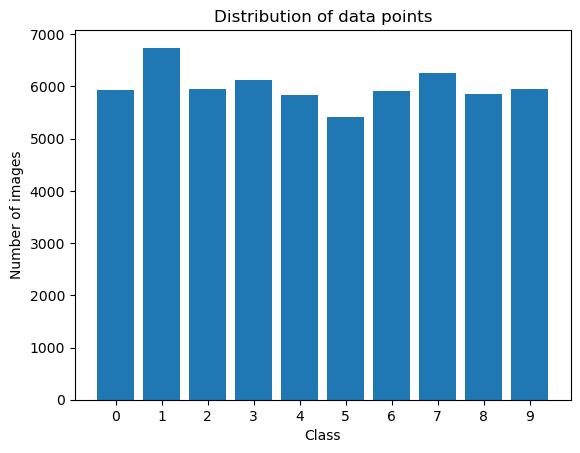

In [13]:
x =  a[0]
y = a[1]
print('Training shape:\nX: ', x.shape, '\nY: ', y.shape)
print(f'The different classes\n{y.unique().detach().numpy()}\nIn total there are {len(y.unique())} Training classes')
#shows the number of classes
 
 
#3
hist = []
yun = y.unique().detach().numpy()
for i in range (len(yun)):
    hist.append(np.sum([ 1 for j in range(x.shape[0]) if y[j] == i]))
plt.bar(yun, hist)
plt.xticks(yun) 
plt.xlabel ('Class')
plt.ylabel('Number of images')
plt.title('Distribution of data points')
#plt.savefig(f'/content/drive/My Drive/EML/A4/histogram', dpi = 400)
plt.show()

In [14]:
#below code sorts the images in their respective classes.
subXTrain = []
subYTrain = []
subXTest = []
subYTest = []

for i in range (2):
    temp = ([ torch.unsqueeze(x[j], 0) for j in range(x.shape[0]) if y[j] == i])
    temp = torch.cat(temp, dim = 0) 
    subXTrain.append(temp)
    temp = ([ torch.unsqueeze(y[j], 0) for j in range(y.shape[0]) if y[j] == i])
    temp = torch.cat(temp, dim = 0) 
    subYTrain.append(temp)
    # temp = ([ torch.unsqueeze(xTest[j], 0) for j in range(xTest.shape[0]) if yTest[j] == i])
    # temp = torch.cat(temp, dim = 0) 
    # subXTest.append(temp)   
    # temp = ([ torch.unsqueeze(yTest[j], 0) for j in range(yTest.shape[0]) if yTest[j] == i])
    # temp = torch.cat(temp, dim = 0) 
    # subYTest.append(temp)

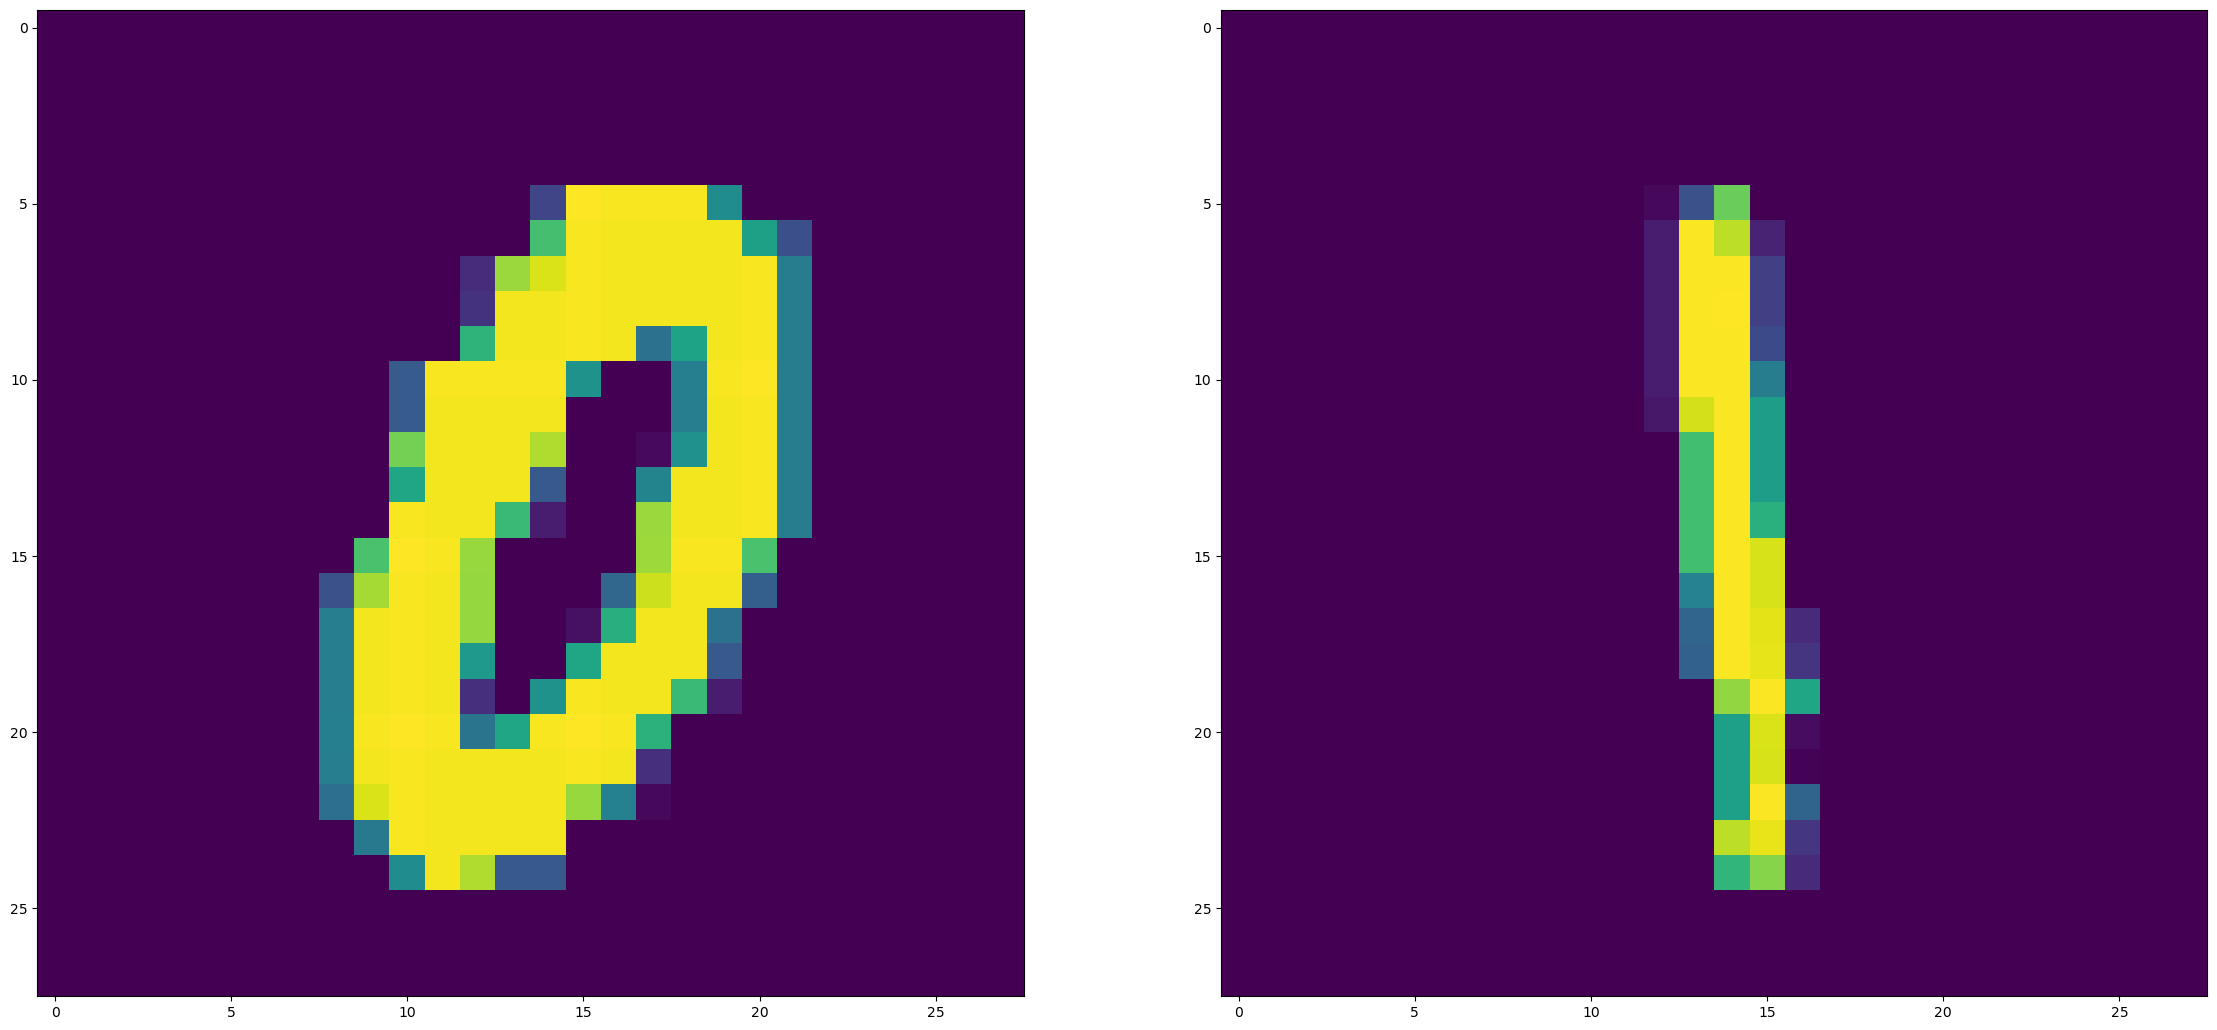

In [15]:
#4 Visualize
fig = plt.figure(figsize=(28, 28))
columns = 2
rows = 1
numItem = 2
for i in range (1, len(subXTrain)+1):    
    img = subXTrain[i-1][numItem].detach().numpy()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
#plt.savefig(f'/content/drive/My Drive/EML/A4/Data_{numItem}.png')
plt.show()


In [16]:
subXTrain[0][0].shape

torch.Size([28, 28])

Best solution is [0.01242053 0.96907533]
Fitness of the best solution is 0.03150823451513846
Best solution found after 42 generations


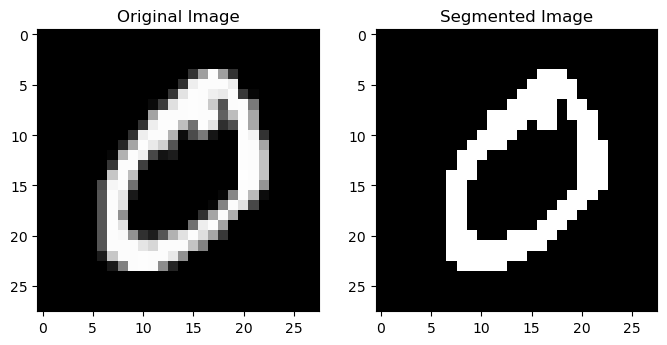

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pygad

def euclidean_distance(X, Y):
    return np.sqrt(np.sum(np.power(X - Y, 2), axis=1))

def segment_data(solution, solution_idx):
    global num_segments, image
    pixel_value_length = image_flat.shape[1]
    segment_centers = []
    all_segments_dists = []
    segments = []
    segments_sum_dist = []

    for seg_idx in range(num_segments):
        segment_centers.append(solution[pixel_value_length * seg_idx:pixel_value_length * (seg_idx + 1)])
        segment_center_dists = euclidean_distance(image_flat, segment_centers[seg_idx])
        all_segments_dists.append(np.array(segment_center_dists))

    segment_centers = np.array(segment_centers)
    all_segments_dists = np.array(all_segments_dists)

    segment_indices = np.argmin(all_segments_dists, axis=0)
    for seg_idx in range(num_segments):
        segments.append(np.where(segment_indices == seg_idx)[0])
        if len(segments[seg_idx]) == 0:
            segments_sum_dist.append(0)
        else:
            segments_sum_dist.append(np.sum(all_segments_dists[seg_idx, segments[seg_idx]]))

    segments_sum_dist = np.array(segments_sum_dist)

    return segment_centers, all_segments_dists, segment_indices, segments, segments_sum_dist

def fitness_func(_, solution, solution_idx):
    _, _, _, _, segments_sum_dist = segment_data(solution, solution_idx)

    fitness = 1.0 / (np.sum(segments_sum_dist) + 0.00000001)
    return fitness

image0 = subXTrain[0][0].detach().cpu().numpy()/255
# Flatten the image matrix
image_flat = image0.flatten().reshape(-1, 1)

# Define the number of clusters (segments)
num_segments = 2
crossover = True
mutation = True

num_genes = num_segments * image_flat.shape[1]

if crossover:
    CrossOver = "single_point"
    crossover_probability = 0.5
else:
    CrossOver = None
    crossover_probability = None

if mutation:
    Mutation = "random"
    mutation_percent_genes = 10
else:
    Mutation = None
    mutation_percent_genes = None


ga_instance = pygad.GA(num_generations=100
                       , sol_per_pop=10
                       , num_parents_mating=5
                       #,init_range_low=0
                       #,init_range_high=1
                       , crossover_type = CrossOver
                       , crossover_probability = crossover_probability
                       , keep_parents=2
                       , num_genes=num_genes
                       , fitness_func=fitness_func
                       , suppress_warnings=True
                       , mutation_percent_genes=mutation_percent_genes
                       , mutation_type = Mutation
                       , mutation_probability = 0.5
                       , save_solutions = True)



ga_instance.run()

best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
print("Best solution is {bs}".format(bs=best_solution))
print("Fitness of the best solution is {bsf}".format(bsf=best_solution_fitness))
print("Best solution found after {gen} generations".format(gen=ga_instance.best_solution_generation))

segment_centers, all_segments_dists, segment_indices, segments, segments_sum_dist = segment_data(best_solution, best_solution_idx)

# Reshape the segmented image to its original shape
final_segmentation0 = np.zeros_like(image0)
for seg_idx in range(num_segments):
    final_segmentation0.flat[segments[seg_idx]] = seg_idx + 1



# Display the original and segmented images using matplotlib
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image0, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(final_segmentation0, cmap='gray')
plt.title('Segmented Image')
plt.show()


Best solution is [0.00846414 0.99094383]
Fitness of the best solution is 0.05765114946700417
Best solution found after 77 generations


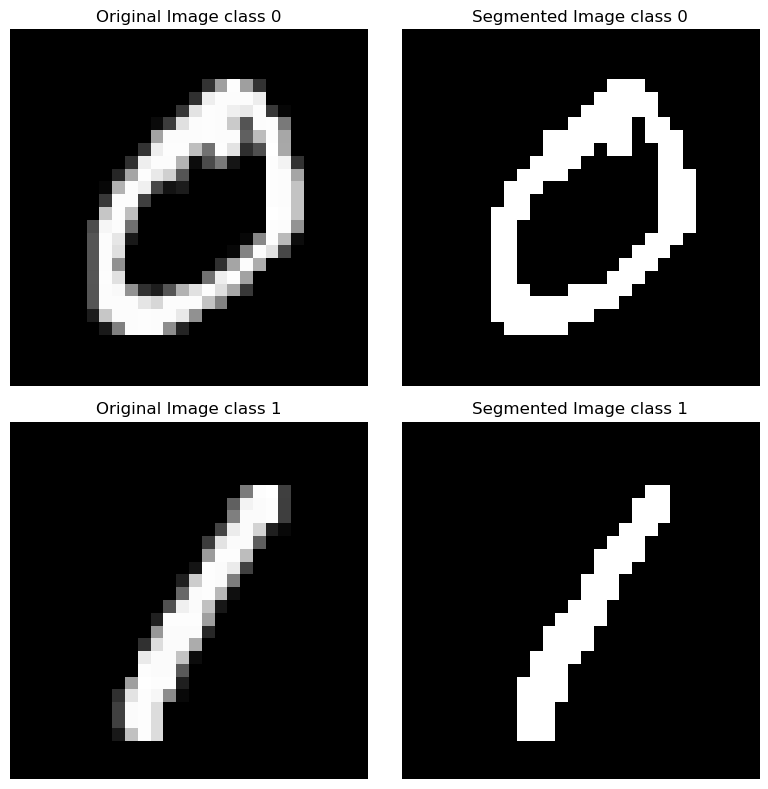

In [21]:
image1 = subXTrain[1][0].detach().cpu().numpy()/255
# Flatten the image matrix
image_flat = image1.flatten().reshape(-1, 1)

# Define the number of clusters (segments)
num_segments = 2
crossover = True
mutation = True

num_genes = num_segments * image_flat.shape[1]

if crossover:
    CrossOver = "single_point"
    crossover_probability = 0.5
else:
    CrossOver = None
    crossover_probability = None

if mutation:
    Mutation = "random"
    mutation_percent_genes = 10
else:
    Mutation = None
    mutation_percent_genes = None


ga_instance = pygad.GA(num_generations=100
                       , sol_per_pop=10
                       , num_parents_mating=5
                       #,init_range_low=0
                       #,init_range_high=1
                       , crossover_type = CrossOver
                       , crossover_probability = crossover_probability
                       , keep_parents=2
                       , num_genes=num_genes
                       , fitness_func=fitness_func
                       , suppress_warnings=True
                       , mutation_percent_genes=mutation_percent_genes
                       , mutation_type = Mutation
                       , mutation_probability = 0.5
                       , save_solutions = True)



ga_instance.run()

best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
print("Best solution is {bs}".format(bs=best_solution))
print("Fitness of the best solution is {bsf}".format(bsf=best_solution_fitness))
print("Best solution found after {gen} generations".format(gen=ga_instance.best_solution_generation))

segment_centers, all_segments_dists, segment_indices, segments, segments_sum_dist = segment_data(best_solution, best_solution_idx)

# Reshape the segmented image to its original shape
final_segmentation1 = np.zeros_like(image1)
for seg_idx in range(num_segments):
    final_segmentation1.flat[segments[seg_idx]] = seg_idx + 1



# Display the original and segmented images using matplotlib
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.axis('off')
plt.imshow(image0, cmap='gray')
plt.title('Original Image class 0')
plt.subplot(2, 2, 2)
plt.imshow(final_segmentation0, cmap='gray')
plt.title('Segmented Image class 0')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(image1, cmap='gray')
plt.title('Original Image class 1')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(final_segmentation1, cmap='gray')
plt.title('Segmented Image class 1')
plt.axis('off')
plt.tight_layout()
output_dir = f'{os.getcwd()}/OutPut'
output_path = f'{output_dir}/MNISTSample.png'
plt.savefig(output_path, dpi=400, bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


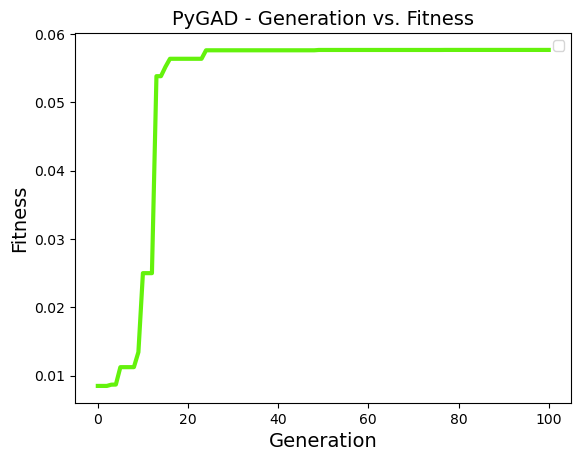

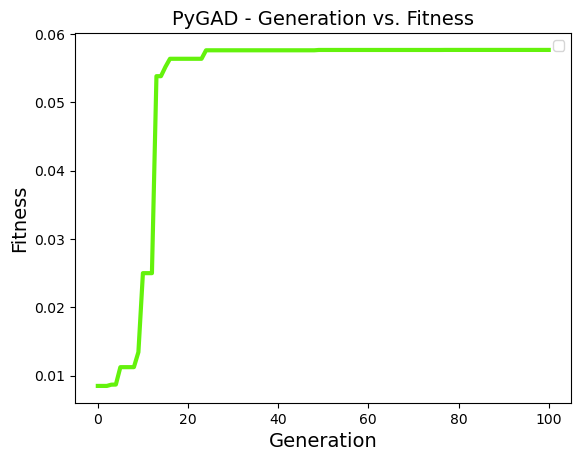

In [22]:
ga_instance.plot_fitness(label='Fitness')

In [ ]:
temp = image1 > 0.5

In [ ]:
f = diceloss()

f.forward(torch.from_numpy(final_segmentation1), torch.from_numpy(temp))


tensor(0.7488, dtype=torch.float64)